# Hybrid Classic-Quantum Systems - Third Assignment #

You should fill in this Jupyter notebook in order to complete the assignment. Here a small recap of the rules:

* You should **NOT** modify the functions that are already provided in the notebook, unless it is strictly necessary;
* If you want to modify the given functions, please, provide an explanation of why you had to;
* You can define new functions, as soon as they are well commented;
* You can import all libraries you want, as soon as you justify their utilization;
* You can add new cells, as soon as you do not remove the cells where you are supposed to comment your solution;
* This is a group assignment. The maximum number of people is 3;
* Your solution should be commented and accompanied by a small description - you can add additional cells if needed;
* For any issue and doubt, please do not hesitate to use the forum or to write me an email.

# Preliminaries #

## Bin Packing Problem (BPP) ##
The bin packing problem (BPP) is an optimization problem. The final goal is to fit items of different sizes into a finite number of bins, each of a fixed given capacity, minimizing the number of bins used. The problem has many applications, ranging from logistics, multi-processor scheduling.

Computationally, the problem is NP-hard, and the corresponding decision problem, deciding if items can fit into a specified number of bins, is NP-complete.
![np-complete](https://imgs.xkcd.com/comics/np_complete.png)

## Mathematical formulation ##
The objective function of BPP is to minimize the number of bins used, more formally,
\begin{align} \label{eqn:bpp}
    & {\min}\
    & &  \sum_{j=1}^{K} B_j \\
    & {\text{subject to}}
    & & g(x_{ij}) = \sum_{j=1}^{K} x_{ij} = 1 \qquad \forall i \\
    & & & h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} \le C*B_j \qquad \forall j
\end{align}

The constraint $g(x)$ implies that each task can be packed into at most one CPU, and constraint $h(x_{ij})$ says that the requirements of each task can not exceed the given $C$ capacity. In this paper, BPP can be considered as a mixture of inequality and equality-constrained optimization problems.

# Loading BPP instances #
First of all, we focus on generating instances of BPP to be used for the evaluation. Each instance is structured in the following way:

$[[w_0, w_1, ..., w_n], C, B, items]$, such that:
* $w_i$ is the weight of item $i$;
* $C$ is the capacity of each bin;
* $B$ is the number of bins;
* $items$ is the number of items

We pre-generated the instances for you and saved them in an attached binary file. You can read them in your code by using the following code:

In [396]:
import pickle

def read_list(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [397]:
# You might need to reupload bpp_instances
instances = read_list("bpp_instances")

# Transforming BPP into a QUBO #
QUBO is a mathematical model that is used to represent combinatorial optimization problems in which the variables are binary $\{0,1\}$ and the objective function with constraints is quadratic. We employ QUBO for BPP because it provides a framework for representing combinatorial optimization problems in a form that can be efficiently solved using quantum computing algorithms designed for QUBO problems, such as VQE or QAOA.

## Slack Variables + Quadratic Penalty Encoding ##
Qiskit Optimization provides with QuadraticProgram a very generic and powerful representation for optimization problems. However, usually, optimization algorithms cannot handle all possible types of problems that can be modelled, but only a sub-class. Many available quantum optimization algorithms can handle Quadratic Unconstrained Binary Optimization (QUBO) problems. To do so, first, it is necessary to convert a given optimization problem into a QUBO.

Qiskit Optimization provides converters to achieve this conversion whenever possible. More precisely, Qiskit Optimization provides the following converters:
* *InequalityToEquality*: converts inequality constraints into equality constraints with additional slack variables.
* *IntegerToBinary* : converts integer variables into binary variables and corresponding coefficients.
* *LinearEqualityToPenalty* : convert equality constraints into additional terms of the object function.
* *QuadraticProgramToQubo* : a wrapper for IntegerToBinary and LinearEqualityToPenalty for convenience.
More information available at: https://qiskit.org/documentation/stable/0.19/tutorials/optimization/2_converters_for_quadratic_programs.html

## Penalty-Based Encoding ##

### Define penalties ###
To enforce the constraints, we introduce penalty terms to the objective function. These terms penalize solutions that violate the constraints. Firsts, we rewrite constraints $g(x_{ij})$ and $h(x_{ij})$ as follows,
     \begin{align*}
        g(x_{ij}) = \sum_{j=1}^{K} x_{ij} - 1 = 0 \qquad \forall i \\
        h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} - C \cdot B_j \le 0 \qquad \forall j \\
    \end{align*}
    Second, introduce penalty functions $p_1(\lambda, g(x))$ and $p_2(\beta, h(x))$ with coefficients $\{\lambda, \beta\} \geq 0 $
    \begin{equation}\label{penalty1}
        p_1(\lambda, g(x_{ij})) =
        \begin{cases}
            0 & \text{if $g(x_{ij}) \leq 0$} \\
            \lambda g(x_{ij}) & \text{if $g(x_{ij}) > 0$}
        \end{cases}
    \end{equation}
    \begin{equation}\label{penalty2}
        p_2(\beta, h(x_{ij})) =
        \begin{cases}
            0 & \text{if $h(x_{ij}) \leq 0$} \\
            \beta h(x_{ij}) & \text{if $h(x_{ij}) > 0$}
        \end{cases}
    \end{equation}
    
In literature, there are multiple methods for penalization such as the exterior penalty function and interior penalty function.

### Injecting Penalties in the Model ###
To get the final QUBO form we combine penalties with objective function and get

\begin{equation}
    \mathcal{F} = \sum_{j=1}^{K} B_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}

### Examples of penalty functions ###
* https://www.stat.cmu.edu/~ryantibs/convexopt-F13/scribes/lec16.pdf
* https://www.rose-hulman.edu/~bryan/lottamath/penalty.pdf

## YOUR TASK ##
* Apply slack + quadratic penalty
* Apply penalty-based encoding using three functions

The following cell installs the required packages for the notebook. If you need the installation, please ensure the variable `install` is set to True.

In [398]:
install = True
if (install):
    !pip install qiskit
    !pip install qiskit_optimization
    !pip install qiskit-optimization[cplex]
    !pip install docplex
    !pip install cplex
    !pip install qiskit-aer
    !pip install seaborn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [399]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import InequalityToEquality, IntegerToBinary, LinearEqualityToPenalty

In [400]:
print("Instances of the problem:")
print(instances)

Instances of the problem:
[[[55, 40, 25, 50], 100, 3, 4], [[80, 20, 55, 15], 120, 3, 4], [[70, 35, 15, 70], 100, 3, 4], [[10, 55, 65, 35], 120, 3, 4], [[35, 40, 45, 50], 100, 3, 4], [[95, 50, 45, 25], 120, 3, 4], [[60, 25, 75, 25], 100, 3, 4], [[55, 10, 60], 120, 2, 3], [[55, 60, 35], 100, 2, 3], [[40, 95, 60], 120, 2, 3], [[55, 50, 5], 100, 2, 3], [[100, 30, 35], 120, 2, 3], [[50, 50, 30], 100, 2, 3], [[30, 60, 75], 120, 2, 3], [[25, 20, 15, 20, 5], 100, 1, 5], [[10, 40, 40, 20, 5], 120, 1, 5], [[10, 20, 25, 15, 25], 100, 1, 5], [[5, 10, 15, 25, 35], 120, 1, 5], [[5, 40, 10, 5, 35], 100, 1, 5], [[40, 35, 10, 15, 20], 120, 1, 5], [[10, 15, 25, 10, 15], 100, 1, 5]]


The following cells define all the steps to define a classical model for BPP and convert it into a QUBO formulation with penalty encoding.

In [401]:
"""
    Defines the classical model for BPP.

    n: number of items
    m: number of bins
    w: weights of the items
    C: capacity of the bins

    returns: classical model for BPP, according to the input parameters
"""
def get_classical_model(n, m, w, C):

    mdl = Model("BPP")

    B = mdl.binary_var_list(m, name='B')
    x = mdl.binary_var_matrix(m, n, name='x')
    mdl.minimize(mdl.sum(B[j] for j in range(m)))

    # adding constraints
    for i in range(n):
        mdl.add_constraint(mdl.sum(x[j, i] for j in range(m)) == 1)

    for j in range(m):
        mdl.add_constraint(mdl.sum(w[i] * x[j, i] for i in range(n)) <= C * B[j])

    return mdl

In [402]:
# Load quadratic program from docplex model
mdl = get_classical_model(instances[0][3], instances[0][2], instances[0][0], instances[0][1])
qp = from_docplex_mp(mdl)
print(type(qp))
print(qp.prettyprint())

<class 'qiskit_optimization.problems.quadratic_program.QuadraticProgram'>
Problem name: BPP

Minimize
  B_0 + B_1 + B_2

Subject to
  Linear constraints (7)
    x_0_0 + x_1_0 + x_2_0 == 1  'c0'
    x_0_1 + x_1_1 + x_2_1 == 1  'c1'
    x_0_2 + x_1_2 + x_2_2 == 1  'c2'
    x_0_3 + x_1_3 + x_2_3 == 1  'c3'
    -100*B_0 + 55*x_0_0 + 40*x_0_1 + 25*x_0_2 + 50*x_0_3 <= 0  'c4'
    -100*B_1 + 55*x_1_0 + 40*x_1_1 + 25*x_1_2 + 50*x_1_3 <= 0  'c5'
    -100*B_2 + 55*x_2_0 + 40*x_2_1 + 25*x_2_2 + 50*x_2_3 <= 0  'c6'

  Binary variables (15)
    B_0 B_1 B_2 x_0_0 x_0_1 x_0_2 x_0_3 x_1_0 x_1_1 x_1_2 x_1_3 x_2_0 x_2_1
    x_2_2 x_2_3



### Problem Simplification

The problem should be simplified to decrease the number of variables and, consequently, the qubits used in the final circuits. This is crucial for a few reasons:
- Qiskit's QAOA solver has a strict limit of 32 qubits, even when using a simulator.
- Running on a real machine or a simulator with limited qubits will pose challenges.
- Regardless of a high number of qubits or a perfect simulator, solving the problem will be extremely time-consuming without reducing the number of variables.

For these reasons, the following optimizations are implemented:
- The minimum number of bins required to cover the total weight of items is chosen a priori, reducing the number of variables.
- It is assumed a priori that the first bin will be allocated to the first item, eliminating one variable. This is true because all bins have the same capacity and the problem is assumed feasible.
- As the first item is placed in the first bin, it is deduced that it won't be present in any other bin, resulting in the removal of a variable for each subsequent bin.

In [403]:
"""
    Simplifies the quadratic problem by reducing variables related to reasonable assumptions.

    qp: quadratic problem with BPP
    n: number of items
    m: number of bins
    w: weights of the items
    C: capacity of the bins

    returns: simplified quadratic problem
"""
def simplify_quadratic_problem(qp, m, w, C):
    min_bins = int(np.ceil(np.sum(w)/C))

    # The minimum number of bins is the one necessary to cover the sum of the items' weight
    # That means the first num_bins bins will be used
    for i in range(min_bins):
        qp = qp.substitute_variables({f"B_{i}": 1})

    # We can assume the first item will be allocated to the first bin
    # This is true because all bins have the same capacity and the problem is assumed feasible
    qp = qp.substitute_variables({"x_0_0": 1})

    # The first item is not in any other bin
    for i in range(1, m):
        qp = qp.substitute_variables({f"x_{i}_0": 0})

    return qp

In [404]:
qp = simplify_quadratic_problem(qp, instances[0][2], instances[0][0], instances[0][1])
print(qp.prettyprint())

Problem name: BPP

Minimize
  B_2 + 2

Subject to
  Linear constraints (6)
    x_0_1 + x_1_1 + x_2_1 == 1  'c1'
    x_0_2 + x_1_2 + x_2_2 == 1  'c2'
    x_0_3 + x_1_3 + x_2_3 == 1  'c3'
    40*x_0_1 + 25*x_0_2 + 50*x_0_3 <= 45  'c4'
    40*x_1_1 + 25*x_1_2 + 50*x_1_3 <= 100  'c5'
    -100*B_2 + 40*x_2_1 + 25*x_2_2 + 50*x_2_3 <= 0  'c6'

  Binary variables (10)
    B_2 x_0_1 x_0_2 x_0_3 x_1_1 x_1_2 x_1_3 x_2_1 x_2_2 x_2_3



In [405]:
"""
    Applies penalty-based encoding to the quadratic problem.

    qp: instace of a quadratic problem

    returns: QUBO version of a quadratic problem
"""
def apply_penalty_encoding(qp):
    ineq_to_eq = InequalityToEquality()
    qp_eq = ineq_to_eq.convert(qp)

    int_to_bin = IntegerToBinary()
    qp_eq_bin = int_to_bin.convert(qp_eq)

    lin_eq_to_penalty = LinearEqualityToPenalty()
    qubo = lin_eq_to_penalty.convert(qp_eq_bin)

    return qubo

qubo_test = apply_penalty_encoding(qp)
print(f"The number of variables is {qubo_test.get_num_vars()}")
print(qubo_test.prettyprint())

The number of variables is 30
Problem name: BPP

Minimize
  20000*B_2^2 - 400*B_2*c6@int_slack@0 - 800*B_2*c6@int_slack@1
  - 1600*B_2*c6@int_slack@2 - 3200*B_2*c6@int_slack@3 - 6400*B_2*c6@int_slack@4
  - 12800*B_2*c6@int_slack@5 - 14800*B_2*c6@int_slack@6 - 16000*B_2*x_2_1
  - 10000*B_2*x_2_2 - 20000*B_2*x_2_3 + 2*c4@int_slack@0^2
  + 8*c4@int_slack@0*c4@int_slack@1 + 16*c4@int_slack@0*c4@int_slack@2
  + 32*c4@int_slack@0*c4@int_slack@3 + 64*c4@int_slack@0*c4@int_slack@4
  + 56*c4@int_slack@0*c4@int_slack@5 + 8*c4@int_slack@1^2
  + 32*c4@int_slack@1*c4@int_slack@2 + 64*c4@int_slack@1*c4@int_slack@3
  + 128*c4@int_slack@1*c4@int_slack@4 + 112*c4@int_slack@1*c4@int_slack@5
  + 32*c4@int_slack@2^2 + 128*c4@int_slack@2*c4@int_slack@3
  + 256*c4@int_slack@2*c4@int_slack@4 + 224*c4@int_slack@2*c4@int_slack@5
  + 128*c4@int_slack@3^2 + 512*c4@int_slack@3*c4@int_slack@4
  + 448*c4@int_slack@3*c4@int_slack@5 + 512*c4@int_slack@4^2
  + 896*c4@int_slack@4*c4@int_slack@5 + 392*c4@int_slack@5^2
 

The following function is a wrapper that returns a QUBO model base don the parameters provided.

In [406]:
"""
    Defines the QUBO model for BPP.

    n: number of items
    m: number of bins
    w: weights of the items
    C: capacity of the bins
    simplify: If True, simplifies the problem by reducing number of variables

    returns: QUBO model for BPP (quadratic problem), according to the input parameters
"""
def get_qubo(n, m, w, C, simplify = True):
    mdl = get_classical_model(n, m, w, C)
    qp = from_docplex_mp(mdl)
    if simplify:
        qp = simplify_quadratic_problem(qp, m, w, C)
    qubo = apply_penalty_encoding(qp)
    return qubo

# Encoding QUBO into ISING Hamiltonian #
The next step is to encode the classical QUBO formulation into a quantum state. There exist techniques to encode classical data into quantum such as basis encoding, amplitude encoding, and angle encoding. In this paper, we apply basis encoding, for which any quantum basis can be chosen, but the common way for doing so is to choose basis $\{-1,1\}$ as follows:
\begin{align}
\label{eqn:to_ising}
    \begin{split}
    x_i = \frac{1-z_i}{2}\\
    z_i*z_j = \sigma_Z^i \otimes \sigma_Z^j \\
    z_i = \sigma_Z^i
    \end{split}
\end{align}
where $\sigma_Z^i$ denotes the Pauli-Z matrix
$\begin{pmatrix}
  1 & 0\\
  0 & -1
\end{pmatrix}$ on the $i$-th qubit.
The eigenvalues of $\text{I} - \frac{Z}{2}$ are $\{-1,1\}$ with corresponding eigenstates $|0\rangle$ and $|1\rangle$. Thus, we switch from Z to $\text{I} - \frac{Z}{2}$, and rewrite the problem as BPP Ising hamiltonian,
\begin{equation} \label{eqn:final_hamiltonian}
    H_{bpp}= \sum_{j=1}^{K} \sigma_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}
where $g_j$ and $h_i$ are now functions of $\sigma$.

## YOUR TASK: Encoding the QUBO as an Ising Hamiltonian ##

The provided function translates the QUBO into an Ising Hamiltonian. Nevertheless, this conversion is unnecessary for solving the problem using quantum algorithms, as the optimizers automatically handle this conversion internally.

In [407]:
"""
    Encodes a quadratic problem instance representing a QUBO as a Ising Hamiltonian.

    qubo: quadratic problem representing a QUBO

    returns: Operator instance representing the Ising Hamiltonian
"""
def encode_qubo_as_ising(qubo):
    operator, _ = qubo.to_ising()
    return operator

In [408]:
operator = encode_qubo_as_ising(qubo_test)
print(operator)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIZ', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIIIIIZ',

# Solving BPP instances #

Solve each problem instances using different methods.

The function below is meant to plot the results of an instance. It takes into consideration whether the problem formulation was optimised beforehand.

In [409]:
"""
    Plots the result of an optimizer.

    result: result of the optimizer
    n: number of items
    m: number of bins
    w: weights of the items
    C: capacity of the bins
    simplify: informs whether the problem was simplified or not
"""
def plot_result(result, n, m, w, C, simplify = True):
    results = result.x

    if simplify:
        # Re-add the simplification variables
        min_bins = int(np.ceil(np.sum(w)/C))
        for _ in range(min_bins):
            results = np.insert(results, 0, 0) # Unused bins
        results = np.insert(results, m, 1) # First item always at first bin
        for bin in range(1, m): # First item is only in first bin
            results = np.insert(results, m + bin * n, 0)

    plt.figure()

    items = results[m:m + m * n].reshape(m, n) * w

    indices = np.arange(m)
    plt.bar(indices, items[:, 0], label=f"Item {0}")

    item_nums = items[:, 0]
    for j in range(1, n):
        plt.bar(indices, items[:, j], bottom=item_nums, label=f"Item {j}")
        item_nums += items[:, j]

    plt.hlines(C, -0.5, m - 0.5, linestyle="--", color="r", label="Capacity")
    plt.xticks(indices)
    plt.xlabel("Bin")
    plt.ylabel("Weight")
    plt.legend()
    plt.show()

## CPLEX optimizer ##
Classic optimizer, to be used as baseline with all the others.

In [410]:
from qiskit_optimization.algorithms import CplexOptimizer
import time

In [411]:
"""
    Solves the classical version of BPP and plots the result.

    instance: instance of BPP

    returns: objective value, elapsed time and whether the optimization was successful
"""
def solve_classical(instance):
  
    n = instance[3]
    m = instance[2]
    w = instance[0]
    C = instance[1]

    mdl = get_classical_model(n, m, w, C)
    qp = from_docplex_mp(mdl)
    qp = simplify_quadratic_problem(qp, m, w, C)

    optimizer = CplexOptimizer()

    start_time = time.perf_counter()
    result = optimizer.solve(qp)
    end_time = time.perf_counter()

    print("Elapsed time:", end_time - start_time)

    print(result)
    plot_result(result, n, m, w, C)

    return result.fval, end_time - start_time, result.status.name == 'SUCCESS'

Elapsed time: 0.01627359993290156
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


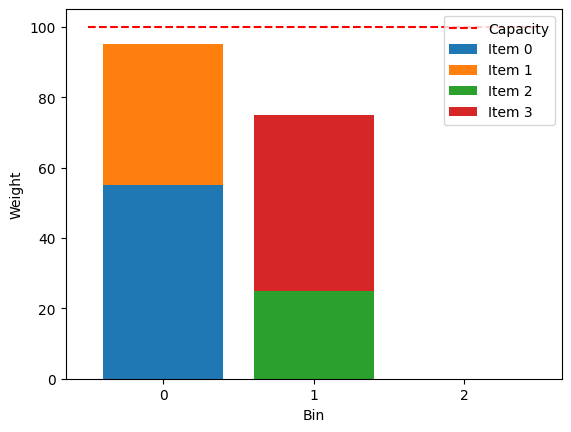

(2.0, 0.01627359993290156, True)

In [412]:
solve_classical(instances[0])

## QAOA solution and Warm start QAOA ##

The implementation of QAOA and warm start QAOA were done in the same method

In [413]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.optimizers import NELDER_MEAD
from qiskit.algorithms.optimizers import SPSA
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer
from qiskit.primitives import Sampler
from qiskit.primitives import BackendSampler
from qiskit.providers.fake_provider import FakePrague
from qiskit import Aer
import time
import pandas as pd
import os

In [414]:
"""
  Solves the QUBO version of BPP and plots the result.

  instance: instance of BPP
  optimizer: optimizer to be used
  backend: backend to be used
  shots: number of shots to be used
  p: p value for QAOAAnsatz
  warm_start: informs whether the warm start technique should be used
  use_perfect_simulator: informs whether the perfect simulator should be used

  returns: objective value, elapsed time and whether the optimization was successful
"""
def solve_qaoa(instance, optimizer, backend, shots, p, warm_start = False, use_perfect_simulator = False):
  
    n = instance[3]
    m = instance[2]
    w = instance[0]
    C = instance[1]

    qubo = get_qubo(n, m, w, C)

    # Because of qiskit limitations, we can either select the backend or the number of shots
    if (not use_perfect_simulator) and shots is None:
        sampler = BackendSampler(backend=backend)
    elif shots is not None: # default backend is used
        sampler = Sampler(options={'shots': shots})
    else:
        sampler = Sampler()

    qaoa = QAOA(sampler, optimizer, reps=p)

    if warm_start:
        optimizer = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa)
    else:
        optimizer = MinimumEigenOptimizer(qaoa)

    if warm_start:
        optimizer = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa)
    else:
        optimizer = MinimumEigenOptimizer(qaoa)

    start_time = time.perf_counter()
    result = optimizer.solve(qubo)
    end_time = time.perf_counter()

    print("Elapsed time:", end_time - start_time)

    print(result)
    plot_result(result, n, m, w, C)

    return result.fval, end_time - start_time, result.status.name == 'SUCCESS'

Before running the models, we should check if no instance is exceeding 32 variables (QAOA's hard limit on Qiskit).

In [415]:
# check if any instance exceeds 32 variables, the maximum for QAOA
exceeds = False
for instance in instances:
    qubo = get_qubo(instance[3], instance[2], instance[0], instance[1])
    if qubo.get_num_vars() > 32:
        print(
            "[WARNING] Instance",
            instance,
            "exceeded 32 variables! The models might fail",
        )
        exceeds = True
if not exceeds:
    print("No instance exceeds 32 variables. Everything should work as expected")

No instance exceeds 32 variables. Everything should work as expected


Elapsed time: 15.570268700015731
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0, c5@int_slack@2=0.0, c5@int_slack@3=1.0, c5@int_slack@4=1.0, c5@int_slack@5=0.0, c5@int_slack@6=0.0, status=SUCCESS


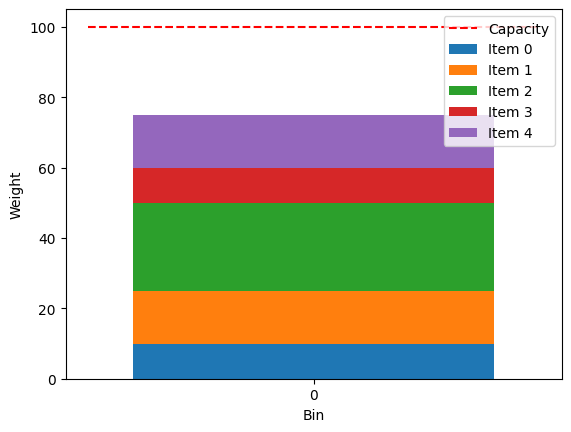

Elapsed time: 8.114180300035514
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0, c5@int_slack@2=0.0, c5@int_slack@3=1.0, c5@int_slack@4=1.0, c5@int_slack@5=0.0, c5@int_slack@6=0.0, status=SUCCESS


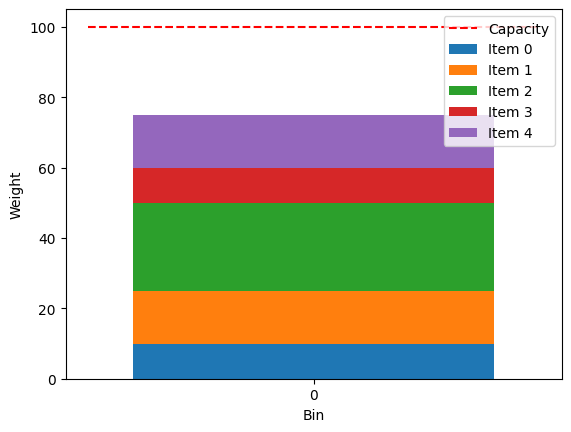

In [416]:
run_quantum = True # Set to False to avoid running the quantum algorithms (time consuming)

if run_quantum:
    solve_qaoa(instances[-1], COBYLA(), None, None, 2, use_perfect_simulator=True)
    solve_qaoa(instances[-1], COBYLA(), None, None, 2, warm_start=True, use_perfect_simulator=True)

# Evaluation #

Evaluate quantum solutions in comparison with classic solution using the following metrics:
* Running time;
* Mean square error between quantum optimum and classic optimum;
* Number of times each algorithm reaches the optimum;

Evaluation should be performed on the following backends:
* Noiseless simulator (Aer)
* Noisy simulator (choose a noise model)
* BONUS: test on AQT simulator (check https://github.com/qiskit-community/qiskit-aqt-provider)

QAOA should be evaluated using different configurations:
* QAOAAnsatz with $p=[1,5]$
* Optimizers: COBYLA, NelderMead, SLSQP
* Shots: {200, 400, 600, 800, 1000} (Please note that AQT backend is limited to 200 shots)
* Optimizers' iteration: {250, 500, 750, 1000}

In [417]:
"""
    Solves the given instance with the chosen parameters with quantum algorithms, both with and without warm start.

    instance: instance to be solved
    backend_name: name of the backend to be used
    backend: backend to be used
    optimizer_name: name of the optimizer to be used
    optimizer: optimizer to be used
    optimizer_iteration: number of iterations of the optimizer
    shots: number of shots to be used
    p: p value of QAOAAnsatz

    returns: results of the quantum algorithms with and without warm start
"""
def solve_and_get_metrics(instance, backend_name, backend, optimizer_name, optimizer, optimizer_iteration, shots, p):
    # qasm and aer have a low qubit number, so we can use QAOA's default perfect simulator
    use_perfect_simulator = backend_name == 'qasm_simulator' or backend_name == 'aer_simulator'

    optimum, time, found = solve_qaoa(instance, optimizer=optimizer, backend=backend, shots=shots, 
                                      p=p, use_perfect_simulator=use_perfect_simulator)
    
    result_qaoa = {'instance': instances.index(instance), 'time': time, 'optimum': optimum, 
                   'found': found, 'optimizer': optimizer_name, 'backend': backend_name, 'shots': shots, 
                   'optimizer_iteration': optimizer_iteration, 'p': p}

    optimum, time, found = solve_qaoa(instance, optimizer=optimizer, backend=backend, shots=shots, 
                                      p=p, warm_start=True, use_perfect_simulator=use_perfect_simulator)
    
    result_warm_start_qaoa = {'instance': instances.index(instance), 'time': time, 'optimum': optimum, 
                              'found': found, 'optimizer': optimizer_name, 'backend': backend_name, 'shots': shots, 
                              'optimizer_iteration': optimizer_iteration, 'p': p}

    return result_qaoa, result_warm_start_qaoa

The subsequent cell outlines the parameters utilized for the experiments. Modification of these parameters is necessary to analyze distinct results and plots.

Following that, the cell establishes dataframes to store the outcomes of various models (classic, QAOA, and QAOA with warm start). Furthermore, it creates a `results` directory.

In [418]:
columns_quantum = ['instance', 'time', 'optimum', 'found', 'optimizer', 'backend', 'shots', 'optimizer_iteration', 'p']
columns_classical = ['instance', 'time', 'optimum', 'found']

backends = {'aer_simulator': Aer.get_backend("qasm_simulator"), 'fake_prague': FakePrague()}
solvers = ['cplex', 'qaoa', 'warm_start_qaoa']

p_list = [1, 2]
optimizers = {'cobyla': COBYLA(), 'nelder_mead': NELDER_MEAD(), 'spsa': SPSA()}
shots_list = [200, 400, 600, 800, 1000]
optimizer_iterations = [250, 500, 750, 1000]

DEFAULT_P = 1
DEFAULT_OPTIMIZER = 'cobyla'
DEFAULT_SHOTS = None
DEFAULT_OPTIMIZER_ITERATION = 1000
DEFAULT_BACKEND = 'aer_simulator'

instances.reverse() # We want to start with the smallest instances

dataframes = {}
dataframes['cplex'] = pd.DataFrame(columns=columns_classical)
dataframes['qaoa'] = pd.DataFrame(columns=columns_quantum)
dataframes['warm_start_qaoa'] = pd.DataFrame(columns=columns_quantum)

# create folder if it does not exist
if not os.path.exists('results'):
    os.makedirs('results')

The next phase involves running experiments with the classical model. This cell is expected to execute rapidly and effortlessly identify the optimum, given the small sizes of the instances for a classical computer.

Elapsed time: 0.015115999965928495
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


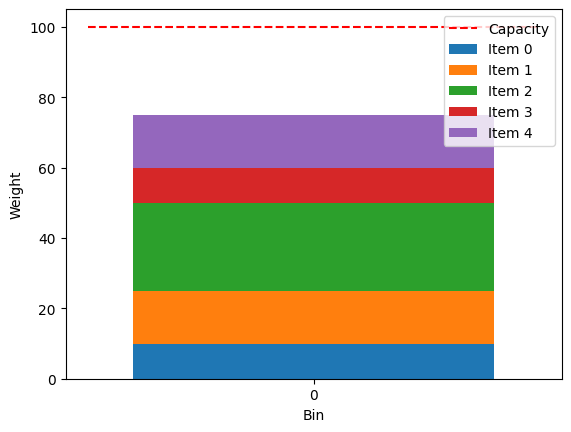

Elapsed time: 0.017141900025308132
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


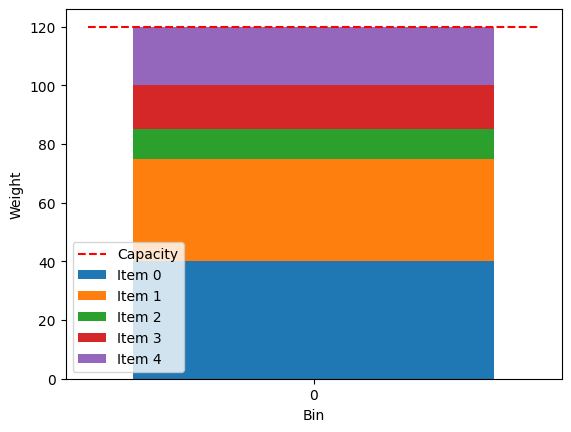

Elapsed time: 0.0111370999366045
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


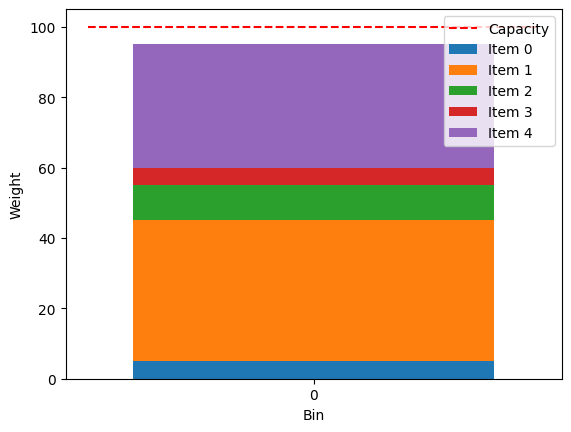

Elapsed time: 0.013497900101356208
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


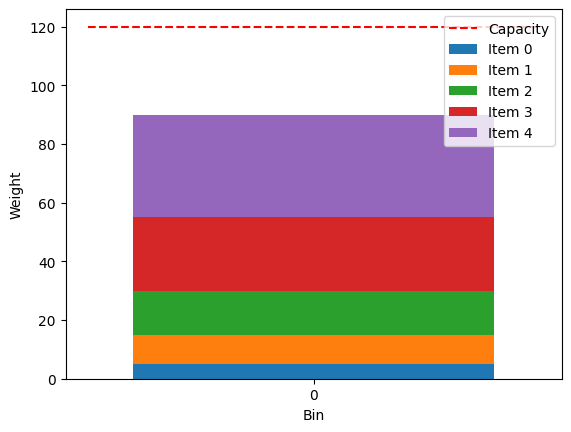

Elapsed time: 0.014304399956017733
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


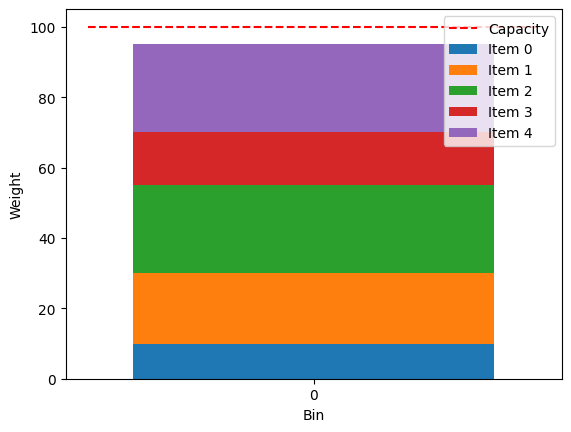

Elapsed time: 0.011985599994659424
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


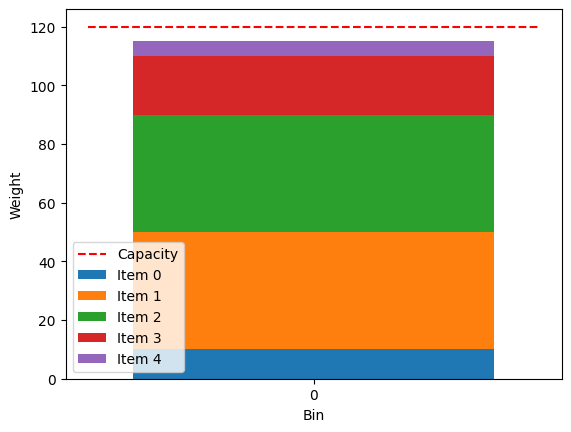

Elapsed time: 0.01140389998909086
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


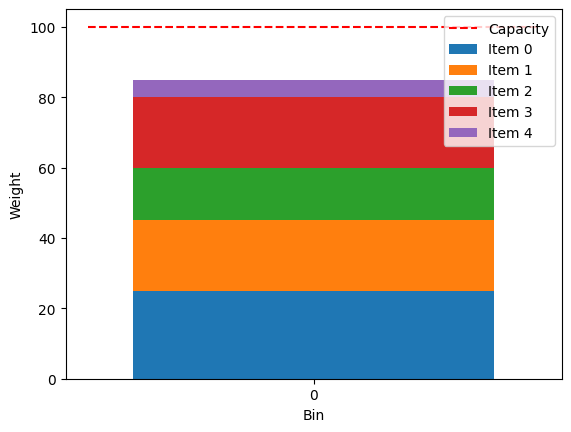

Elapsed time: 0.011176200001500547
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


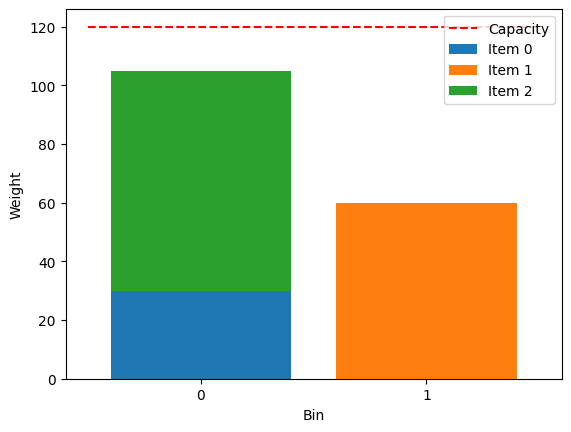

Elapsed time: 0.011566899949684739
fval=2.0, x_0_1=1.0, x_0_2=0.0, x_1_1=0.0, x_1_2=1.0, status=SUCCESS


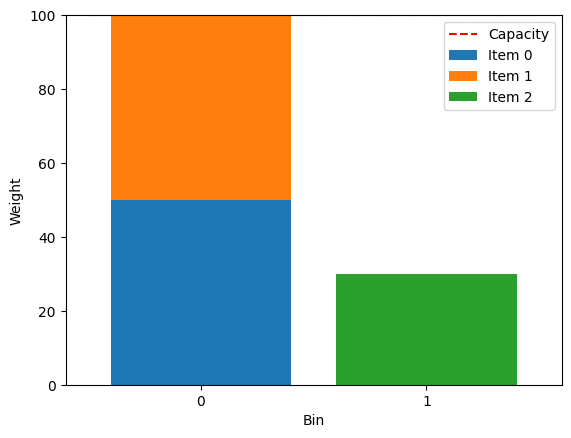

Elapsed time: 0.012203599908389151
fval=2.0, x_0_1=0.0, x_0_2=0.0, x_1_1=1.0, x_1_2=1.0, status=SUCCESS


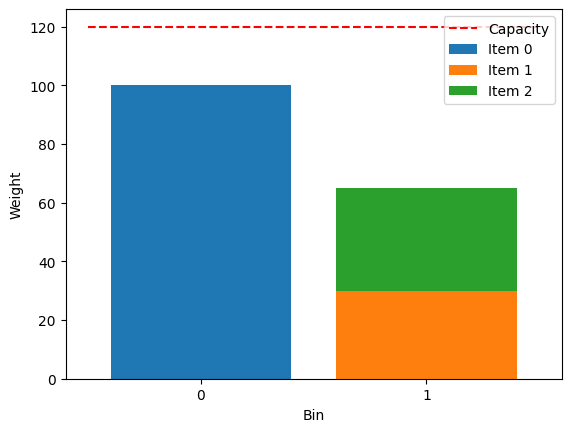

Elapsed time: 0.01382609992288053
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


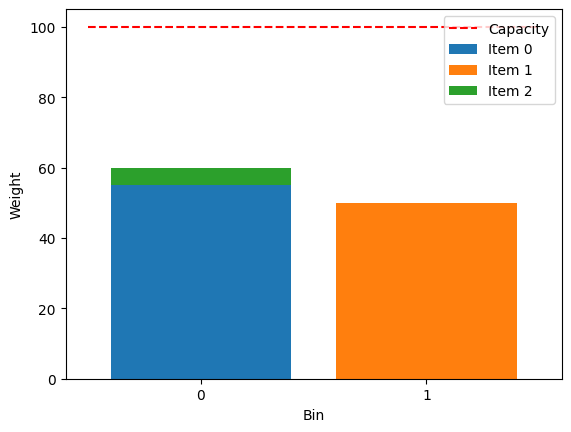

Elapsed time: 0.01273150008637458
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


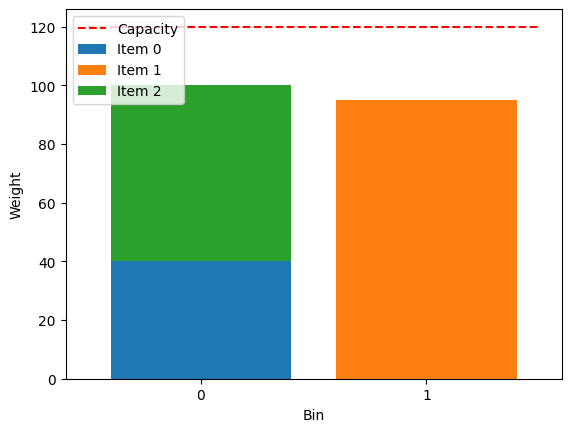

Elapsed time: 0.013649699976667762
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


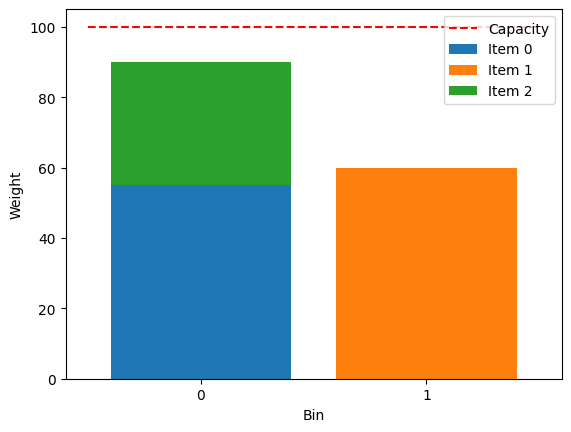

Elapsed time: 0.013642999925650656
fval=2.0, x_0_1=0.0, x_0_2=0.0, x_1_1=1.0, x_1_2=1.0, status=SUCCESS


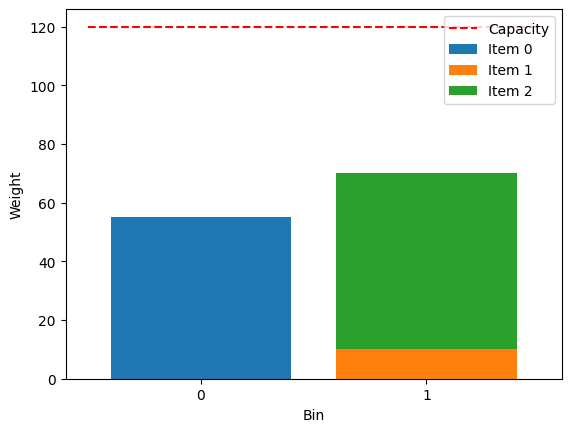

Elapsed time: 0.01699679996818304
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


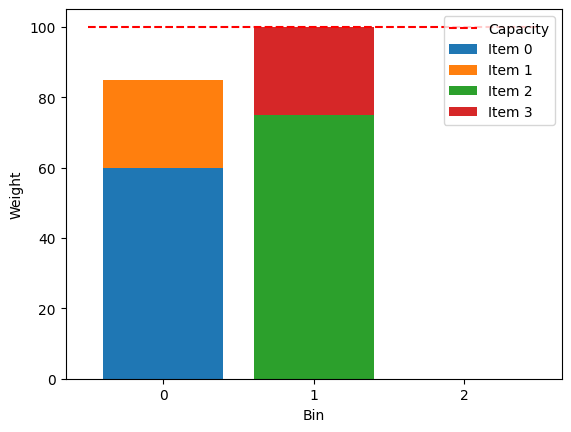

Elapsed time: 0.013200600049458444
fval=2.0, B_2=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=0.0, x_1_1=1.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


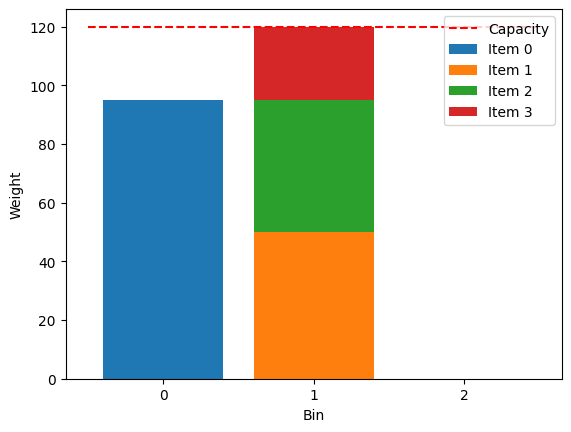

Elapsed time: 0.01813620002940297
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


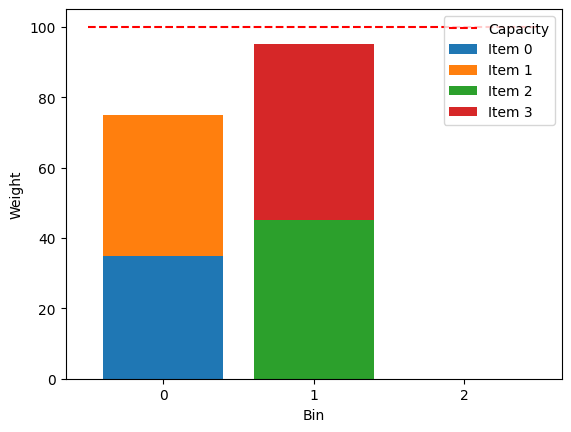

Elapsed time: 0.01340249995701015
fval=2.0, B_2=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_1=1.0, x_1_2=1.0, x_1_3=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


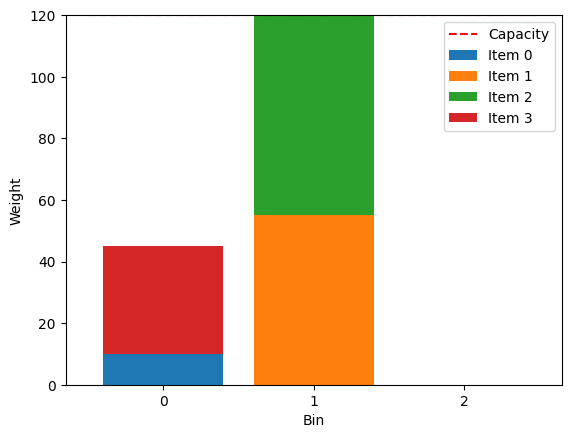

Elapsed time: 0.01252099999692291
fval=3.0, B_2=1.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


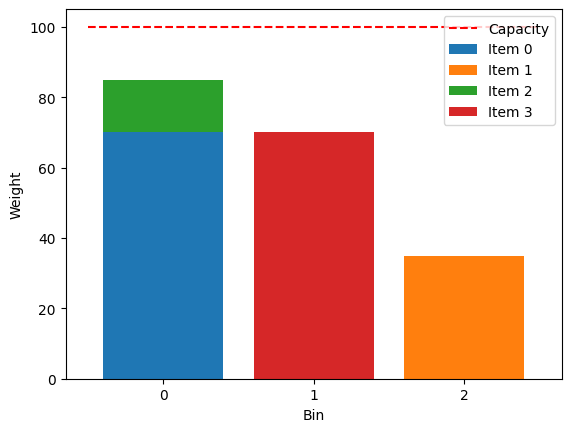

Elapsed time: 0.012399900006130338
fval=2.0, B_2=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_1=1.0, x_1_2=1.0, x_1_3=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


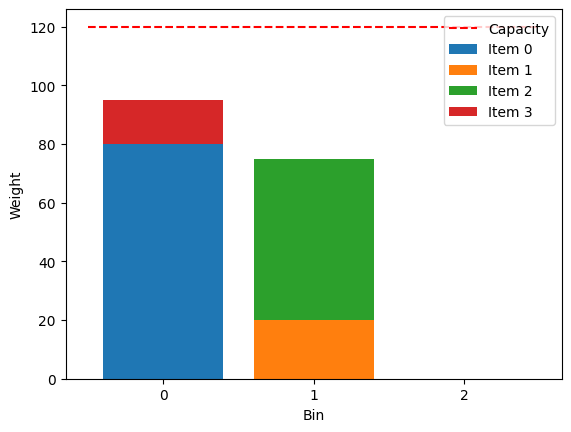

Elapsed time: 0.014527399907819927
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


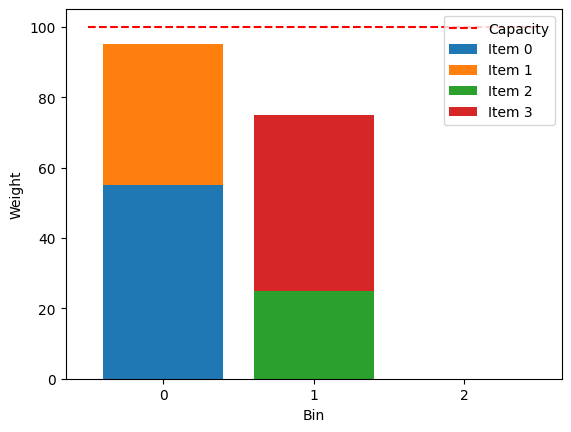

In [419]:
run_classical = True
if run_classical:
    for instance in instances:
        optimum, elapsed_time, found = solve_classical(instance)
        new_row = {'instance': instances.index(instance), 'time': elapsed_time, 'optimum': optimum, 'found': found}
        dataframes['cplex'] = pd.concat([dataframes['cplex'], pd.DataFrame([new_row])], ignore_index=True)
        dataframes['cplex'].to_csv('data/cplex.csv', index=False)

The subsequent cells execute experiments with all the specified parameters in the two quantum models (QAOA and QAOA with warm start), saving the results to a `data/` folder. This final step is crucial as the models require a **considerable amount of time** to run. Pausing execution and resuming at a later time without losing results is facilitated by saving the outcomes.

In our case, a combination of local resources and Kaggle's backend for Jupyter notebooks was utilized, providing ample resources (12 hours quota, 30GB RAM, 4 CPU cores, 73GB disk, GPU access).

Efforts were made to employ Qiskit's GPU support. Locally, this was unfeasible due to Qiskit's exclusive support for CUDA, and a compatible GPU was unavailable within the group. Despite Kaggle providing a CUDA GPU, it appeared insufficient, leading to early model crashes. Consequently, Kaggle's CPU approach proved to be the most viable.

In [420]:
"""
    Runs the quantum algorithms for the given instance, backend, optimizer, optimizer iteration, shots and p.
    Saves the results in the dataframes and in the csv files.

    instance: instance to be solved
    backend_name: name of the backend to be used
    backend: backend to be used
    optimizer_name: name of the optimizer to be used
    optimizer: optimizer to be used
    optimizer_iteration: number of iterations of the optimizer
    shots: number of shots to be used
    p: p value of QAOAAnsatz
    data_qaoa: list to save the results of the quantum algorithms
    data_warm_start_qaoa: list to save the results of the quantum algorithms with warm start
"""
def compute_metrics(instance, backend_name, backend, optimizer_name, optimizer, 
                    optimizer_iteration, shots, p, data_qaoa, data_warm_start_qaoa):
    print(f"Running instance {instances.index(instance)} with {backend_name}, {optimizer_name}, {shots} shots, {p} p, {optimizer_iteration} iterations")
    qaoa, ws_qaoa = solve_and_get_metrics(instance, backend_name, backend, optimizer_name, 
                                          optimizer, optimizer_iteration, shots, p)
    data_qaoa.append(qaoa)
    df = pd.DataFrame(data_qaoa)
    df.to_csv('data/qaoa.csv', index=False)
    data_warm_start_qaoa.append(ws_qaoa)
    df = pd.DataFrame(data_warm_start_qaoa)
    df.to_csv('data/warm_start_qaoa.csv', index=False)

[[10, 15, 25, 10, 15], 100, 1, 5]
Running instance 0 with aer_simulator, cobyla, None shots, 1 p, 1000 iterations
Elapsed time: 4.450793399941176
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0, c5@int_slack@2=0.0, c5@int_slack@3=1.0, c5@int_slack@4=1.0, c5@int_slack@5=0.0, c5@int_slack@6=0.0, status=SUCCESS


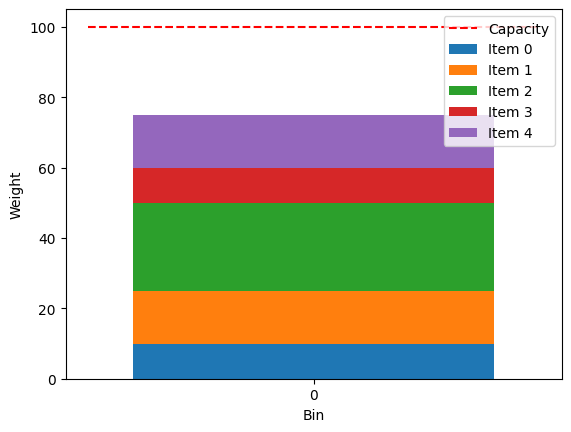

Elapsed time: 4.213627799996175
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0, c5@int_slack@2=0.0, c5@int_slack@3=1.0, c5@int_slack@4=1.0, c5@int_slack@5=0.0, c5@int_slack@6=0.0, status=SUCCESS


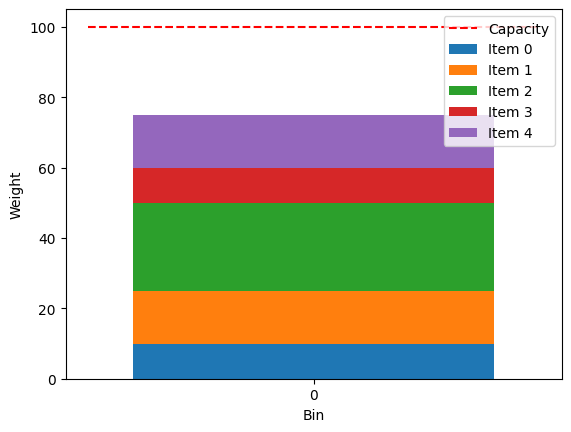

Running instance 0 with aer_simulator, cobyla, None shots, 2 p, 1000 iterations
Elapsed time: 6.85768279992044
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0, c5@int_slack@2=0.0, c5@int_slack@3=1.0, c5@int_slack@4=1.0, c5@int_slack@5=0.0, c5@int_slack@6=0.0, status=SUCCESS


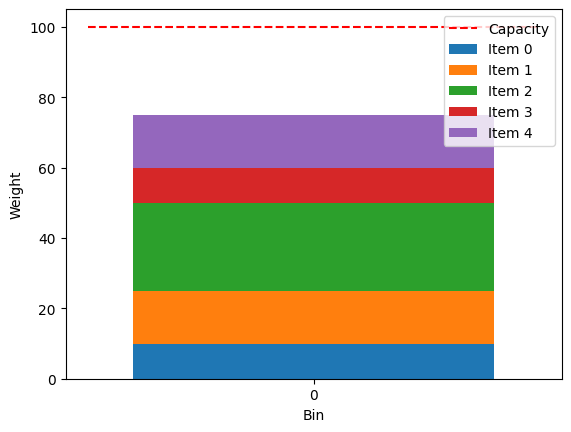

Elapsed time: 6.8417772999964654
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0, c5@int_slack@2=0.0, c5@int_slack@3=1.0, c5@int_slack@4=1.0, c5@int_slack@5=0.0, c5@int_slack@6=0.0, status=SUCCESS


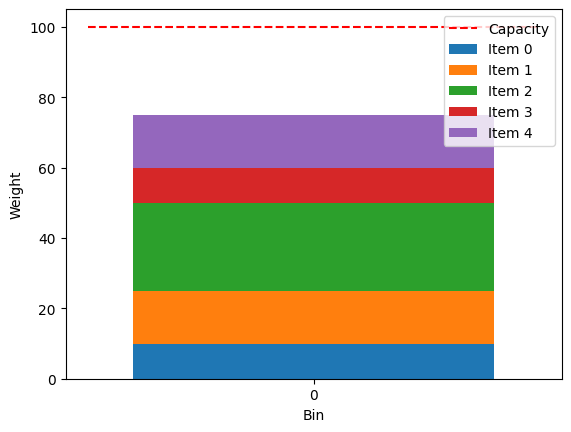

Running instance 0 with aer_simulator, cobyla, None shots, 1 p, 1000 iterations
Elapsed time: 4.220366400084458
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0, c5@int_slack@2=0.0, c5@int_slack@3=1.0, c5@int_slack@4=1.0, c5@int_slack@5=0.0, c5@int_slack@6=0.0, status=SUCCESS


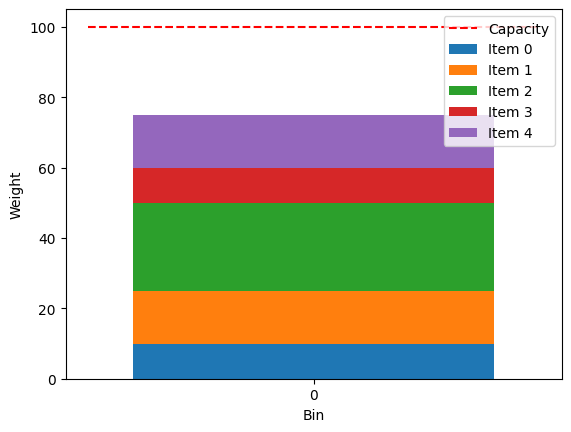

Elapsed time: 4.046421100036241
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0, c5@int_slack@2=0.0, c5@int_slack@3=1.0, c5@int_slack@4=1.0, c5@int_slack@5=0.0, c5@int_slack@6=0.0, status=SUCCESS


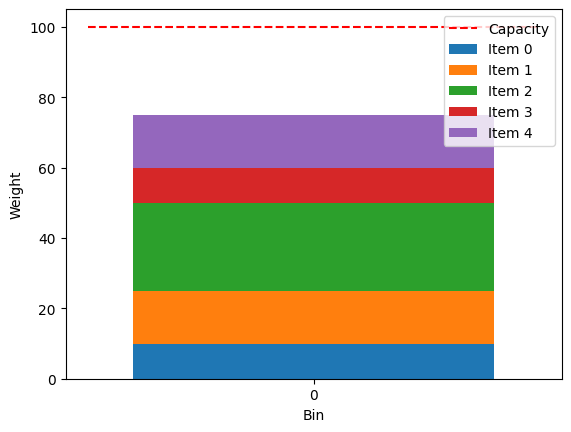

Running instance 0 with aer_simulator, nelder_mead, None shots, 1 p, 1000 iterations
Elapsed time: 14.693663900019601
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0, c5@int_slack@2=0.0, c5@int_slack@3=1.0, c5@int_slack@4=1.0, c5@int_slack@5=0.0, c5@int_slack@6=0.0, status=SUCCESS


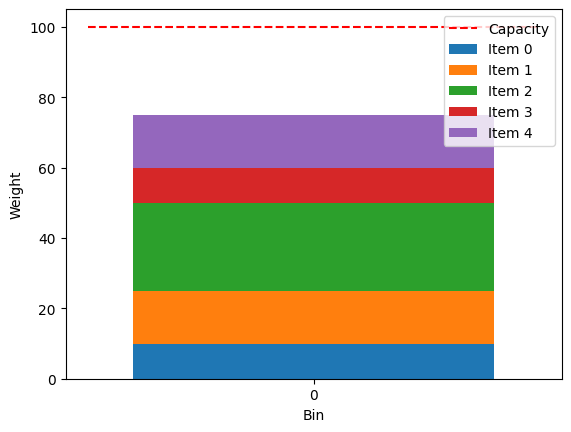

KeyboardInterrupt: 

In [421]:
# Be aware that running the quantum algorithms will take a long time and consume a lot of resources
# Set run_quantum to False to avoid running the quantum algorithms

run_quantum = True

if run_quantum:
    data_qaoa = []
    data_warm_start_qaoa = []
    for instance in instances:
        print(instance)
        try:
            for p in p_list:
                compute_metrics(instance, DEFAULT_BACKEND, backends[DEFAULT_BACKEND], DEFAULT_OPTIMIZER, optimizers[DEFAULT_OPTIMIZER], 
                                DEFAULT_OPTIMIZER_ITERATION, DEFAULT_SHOTS, p, data_qaoa, data_warm_start_qaoa)
            for optimizer_name, optimizer in optimizers.items():
                compute_metrics(instance, DEFAULT_BACKEND, backends[DEFAULT_BACKEND], optimizer_name, optimizer, 
                                DEFAULT_OPTIMIZER_ITERATION, DEFAULT_SHOTS, DEFAULT_P, data_qaoa, data_warm_start_qaoa)
            for optimizer_iteration in optimizer_iterations:
                cobyla_optimizer = COBYLA(maxiter=optimizer_iteration)
                compute_metrics(instance, DEFAULT_BACKEND, backends[DEFAULT_BACKEND], DEFAULT_OPTIMIZER, cobyla_optimizer, optimizer_iteration, 
                                DEFAULT_SHOTS, DEFAULT_P, data_qaoa, data_warm_start_qaoa)
            for backend_name, backend in backends.items():
                compute_metrics(instance, DEFAULT_BACKEND, backends[DEFAULT_BACKEND], DEFAULT_OPTIMIZER, optimizers[DEFAULT_OPTIMIZER], 
                                DEFAULT_OPTIMIZER_ITERATION, DEFAULT_SHOTS, DEFAULT_P, data_qaoa, data_warm_start_qaoa)
            for shots in shots_list:
                compute_metrics(instance, DEFAULT_BACKEND, None, DEFAULT_OPTIMIZER, optimizers[DEFAULT_OPTIMIZER], 
                                DEFAULT_OPTIMIZER_ITERATION, shots, DEFAULT_P, data_qaoa, data_warm_start_qaoa)
        except Exception as e:
            print(f"Error for instance {instance}")
            print(e)

### Metrics

The subsequent cells read the experiment results from the CSV files, compute the relevant metrics, print them, and display various plots comparing the different configurations of the three models (classical, QAOA, and QAOA with warm start).

It's important to note that the code assumes either the quantum models have been executed or the results have been imported from an external source.

In [678]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [679]:
# load dataframes from csv
csv_data = {}
csv_data['cplex'] = pd.read_csv('data/kaggle_cplex.csv')
csv_data['qaoa'] = pd.read_csv('data/kaggle_qaoa.csv')
csv_data['warm_start_qaoa'] = pd.read_csv('data/kaggle_warm_start_qaoa.csv')
for key in csv_data:
    if key != 'cplex':
        csv_data[key].drop_duplicates(subset=['instance', 'backend', 'shots', 'optimizer', 'optimizer_iteration', 'p'], 
                                      keep="last", inplace=True)
csv_data['cplex'] = csv_data['cplex'][csv_data['cplex']['instance'].isin(csv_data['qaoa']['instance'])]

In [680]:
def get_intersection_df(df, optimizer_name, optimizer_iteration, p, shots, backend):
    if shots is not None:
        return df[(df['optimizer'] == optimizer_name) & (df['optimizer_iteration'] == optimizer_iteration) & (df['p'] == p) & (df['shots'] == shots) & (df['backend'] == backend)]
    return df[(df['optimizer'] == optimizer_name) & (df['optimizer_iteration'] == optimizer_iteration) & (df['p'] == p) & (df['shots'].isna()) & (df['backend'] == backend)]

In [681]:
"""
    Computes the mean squared error between the quantum and classical results.
    The parameters are used to filter the results.

    optimizer_name: name of the optimizer used
    shots: number of shots used
    optimizer_iteration: number of iterations of the optimizer used
    p: p value of QAOAAnsatz used
    dfs: dataframes with the results
    warm_start: informs whether the warm start technique was used

    returns: mean squared error between the quantum and classical results
"""
def compute_mse(optimizer_name, shots, optimizer_iteration, p, backend, dfs, warm_start=False):
    df_name = 'warm_start_qaoa' if warm_start else 'qaoa'
    qaoa_results = get_intersection_df(dfs[df_name], optimizer_name, optimizer_iteration, p, shots, backend)
    classical_results = dfs['cplex']
    mse = 0
    for _, qaoa_row in qaoa_results.iterrows():
        classical_row = classical_results[classical_results['instance'] == qaoa_row['instance']]
        if not classical_row.empty:
            mse += (qaoa_row['optimum'] - classical_row['optimum'].values[0])**2
    mse /= len(qaoa_results)
    return mse

In [682]:
"""
    Computes the number of times the quantum algorithm found the optimum, by comparing to the classical results.

    optimizer_name: name of the optimizer used
    shots: number of shots used
    optimizer_iteration: number of iterations of the optimizer used
    p: p value of QAOAAnsatz used
    dfs: dataframes with the results
    warm_start: informs whether the warm start technique was used

    returns: number of times the quantum algorithm found the optimum
"""
def compute_optimum_quantity(optimizer_name, shots, optimizer_iteration, p, backend, dfs, warm_start = False):
    df_name = 'warm_start_qaoa' if warm_start else 'qaoa'
    qaoa_results = get_intersection_df(dfs[df_name], optimizer_name, optimizer_iteration, p, shots, backend)
    classical_results = dfs["cplex"]

    # Merge the two dataframes on the 'instance' column
    merged_results = pd.merge(
        qaoa_results, classical_results, on="instance", suffixes=("_qaoa", "_cplex")
    )

    # Compare the 'optimum' column from both dataframes
    optimum_quantity = np.sum(
        merged_results["optimum_qaoa"] == merged_results["optimum_cplex"]
    )
    return optimum_quantity

In [683]:
"""
    Computes the mean, minimum and maximum execution time of the quantum algorithm.

    optimizer_name: name of the optimizer used
    shots: number of shots used
    optimizer_iteration: number of iterations of the optimizer used
    p: p value of QAOAAnsatz used
    dfs: dataframes with the results
    warm_start: informs whether the warm start technique was used

    returns: mean, minimum and maximum execution time of the quantum algorithm
"""
def compute_execution_metrics(optimizer_name, shots, optimizer_iteration, p, backend, dfs, warm_start = False):
    
    df_name = 'warm_start_qaoa' if warm_start else 'qaoa'
    qaoa_results = get_intersection_df(dfs[df_name], optimizer_name, optimizer_iteration, p, shots, backend)

    mean_time = np.mean(qaoa_results["time"])
    min_time = np.min(qaoa_results["time"])
    max_time = np.max(qaoa_results["time"])

    return mean_time, min_time, max_time

In [684]:
"""
    Calculates the metrics for the quantum algorithm.

    optimizer_name: name of the optimizer used
    shots: number of shots used
    optimizer_iteration: number of iterations of the optimizer used
    p: p value of QAOAAnsatz used
    dfs: dataframes with the results
    warm_start: informs whether the warm start technique was used

    returns: metrics for the quantum algorithm
"""
def calculate_metrics(optimizer_name, shots, optimizer_iteration, p, backend, dfs, warm_start=False):
    mse = compute_mse(
        optimizer_name, shots, optimizer_iteration, p, backend, dfs, warm_start=warm_start
    )
    optimum_quantity = compute_optimum_quantity(
        optimizer_name, shots, optimizer_iteration, p, backend, dfs, warm_start=warm_start
    )
    mean_time, min_time, max_time = compute_execution_metrics(
        optimizer_name, shots, optimizer_iteration, p, backend, dfs, warm_start=warm_start
    )

    results = {
        "optimizer": optimizer_name,
        "shots": shots,
        "optimizer_iteration": optimizer_iteration,
        "p": p,
        "backend": backend,
        "mse": mse,
        "optimum_quantity": optimum_quantity,
        "mean_time": mean_time,
        "min_time": min_time,
        "max_time": max_time,
        "warmup": "Yes" if warm_start else "No",
    }

    return results

The subsequent cell iterates through all configurations, computes the relevant metrics for each one, prints the results, and stores them in a new dataframe.

In [685]:
classic_mean_time = np.mean(csv_data["cplex"]["time"])
classic_min_time = np.min(csv_data["cplex"]["time"])
classic_max_time = np.max(csv_data["cplex"]["time"])

# Compute mean square error for all combinations
results = []

for optimizer_name in optimizers.keys():
    res = calculate_metrics(optimizer_name, DEFAULT_SHOTS, DEFAULT_OPTIMIZER_ITERATION, DEFAULT_P, DEFAULT_BACKEND, csv_data)
    res_warmup = calculate_metrics(optimizer_name, DEFAULT_SHOTS, DEFAULT_OPTIMIZER_ITERATION, DEFAULT_P, DEFAULT_BACKEND, csv_data, warm_start=True)
    results.append(res)
    results.append(res_warmup)

for shots in shots_list:
    res = calculate_metrics(DEFAULT_OPTIMIZER, shots, DEFAULT_OPTIMIZER_ITERATION, DEFAULT_P, DEFAULT_BACKEND, csv_data)
    res_warmup = calculate_metrics(DEFAULT_OPTIMIZER, shots, DEFAULT_OPTIMIZER_ITERATION, DEFAULT_P, DEFAULT_BACKEND, csv_data, warm_start=True)
    results.append(res)
    results.append(res_warmup)

for optimizer_iteration in optimizer_iterations:
    res = calculate_metrics(DEFAULT_OPTIMIZER, DEFAULT_SHOTS, optimizer_iteration, DEFAULT_P, DEFAULT_BACKEND, csv_data)
    res_warmup = calculate_metrics(DEFAULT_OPTIMIZER, DEFAULT_SHOTS, optimizer_iteration, DEFAULT_P, DEFAULT_BACKEND, csv_data, warm_start=True)
    results.append(res)
    results.append(res_warmup)

for p in p_list:
    res = calculate_metrics(DEFAULT_OPTIMIZER, DEFAULT_SHOTS, DEFAULT_OPTIMIZER_ITERATION, p, DEFAULT_BACKEND, csv_data)
    res_warmup = calculate_metrics(DEFAULT_OPTIMIZER, DEFAULT_SHOTS, DEFAULT_OPTIMIZER_ITERATION, p, DEFAULT_BACKEND, csv_data, warm_start=True)
    results.append(res)
    results.append(res_warmup)

res = calculate_metrics(DEFAULT_OPTIMIZER, DEFAULT_SHOTS, DEFAULT_OPTIMIZER_ITERATION, DEFAULT_P, 'fake_prague', csv_data)
res_warmup = calculate_metrics(DEFAULT_OPTIMIZER, DEFAULT_SHOTS, DEFAULT_OPTIMIZER_ITERATION, DEFAULT_P, 'fake_prague', csv_data, warm_start=True)
results.append(res)
results.append(res_warmup)

# Print evaluation results

print("Mean time for classical:", classic_mean_time)
print("Min time for classical:", classic_min_time)
print("Max time for classical:", classic_max_time, "\n")

print("\nEvaluations for QAOA:\n")

for result in results:
    print(
        f"Optimizer: {result['optimizer']}, Shots: {result['shots']}, Optimizer Iteration: " +
        f"{result['optimizer_iteration']}, p: {result['p']}, Backend: {result['backend']}, " +
        f"MSE: {result['mse']}, No. of optimum solutions: {result['optimum_quantity']}, Mean time: {result['mean_time']}, Min time: " +
        f"{result['min_time']}, Max time: {result['max_time']}, Warmup: {result['warmup']}"
    )

df = pd.DataFrame(results)

     instance        time  optimum  found optimizer        backend  shots  \
8           0   10.060149      1.0   True    cobyla  aer_simulator    NaN   
22          1    9.028105      1.0   True    cobyla  aer_simulator    NaN   
36          2    8.961130      1.0   True    cobyla  aer_simulator    NaN   
50          3    9.165902      1.0   True    cobyla  aer_simulator    NaN   
64          4    9.841845      1.0   True    cobyla  aer_simulator    NaN   
78          5    8.195234      1.0   True    cobyla  aer_simulator    NaN   
92          6    8.698071      1.0   True    cobyla  aer_simulator    NaN   
106         8  511.172873      2.0   True    cobyla  aer_simulator    NaN   
119         9  213.514464      2.0   True    cobyla  aer_simulator    NaN   
133        10  470.718459      2.0   True    cobyla  aer_simulator    NaN   
147        12  416.899236      2.0   True    cobyla  aer_simulator    NaN   

     optimizer_iteration  p  
8                   1000  1  
22             

In [686]:
import warnings # Ignore deprecated warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [690]:
"""
    Plots the results of the quantum algorithms with a given feature. Saves the plot as a .png file under 'plots/'.

    df: dataframe with the results
    x: feature to be plotted
"""
def plot_feature(df, x):
    palette = "viridis"

    if x == "backend":
        df = df[df["backend"] != DEFAULT_BACKEND]

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    sns.barplot(x=x, y="mse", data=df, palette=palette, ci=None, hue="warmup")
    plt.title("MSE")
    plt.subplot(1, 3, 2)
    sns.barplot(x=x, y="optimum_quantity", data=df, palette=palette, ci=None, hue="warmup")
    plt.title("Number of optimum solutions")
    plt.subplot(1, 3, 3)
    sns.barplot(x=x, y="mean_time", data=df, palette=palette, ci=None, hue="warmup")
    plt.title("Mean time")

    plt.savefig(f"plots/{x}.png")
    plt.show()

In [691]:
"""
    Plots the results of the quantum algorithms with all features. Saves the plots as .png files under 'plots/'.

    df: dataframe with the results
"""
def plot_results(df):
    if not os.path.exists('plots'):
        os.makedirs('plots')
    features = ['optimizer', 'shots', 'optimizer_iteration', 'p', 'backend']
    for feature in features:
       plot_feature(df, feature)

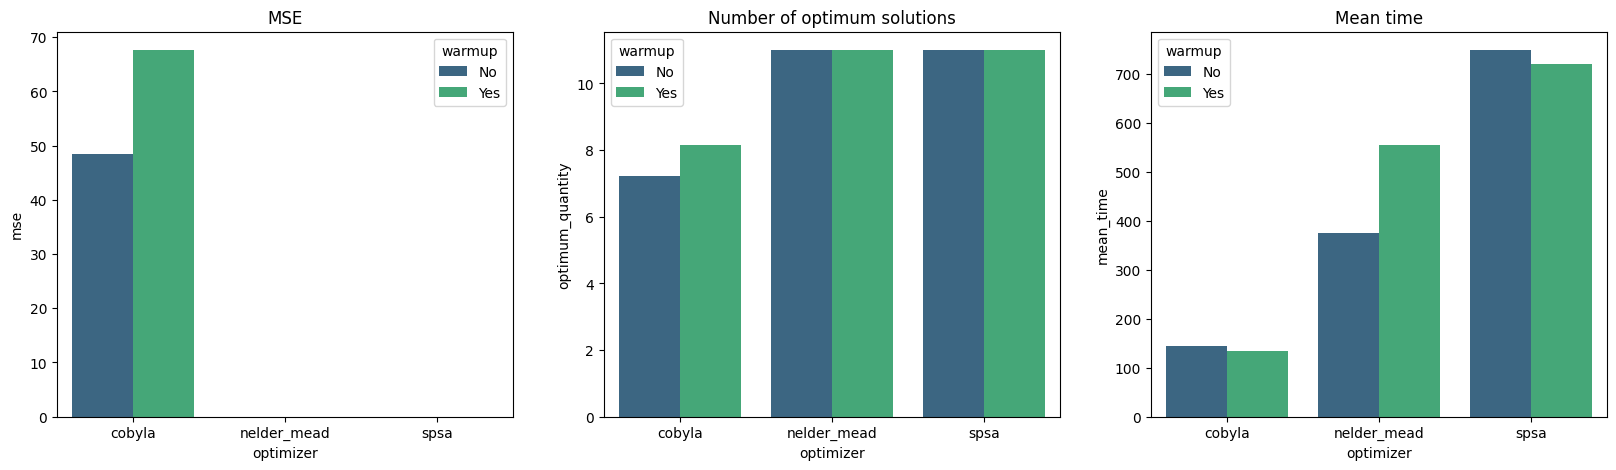

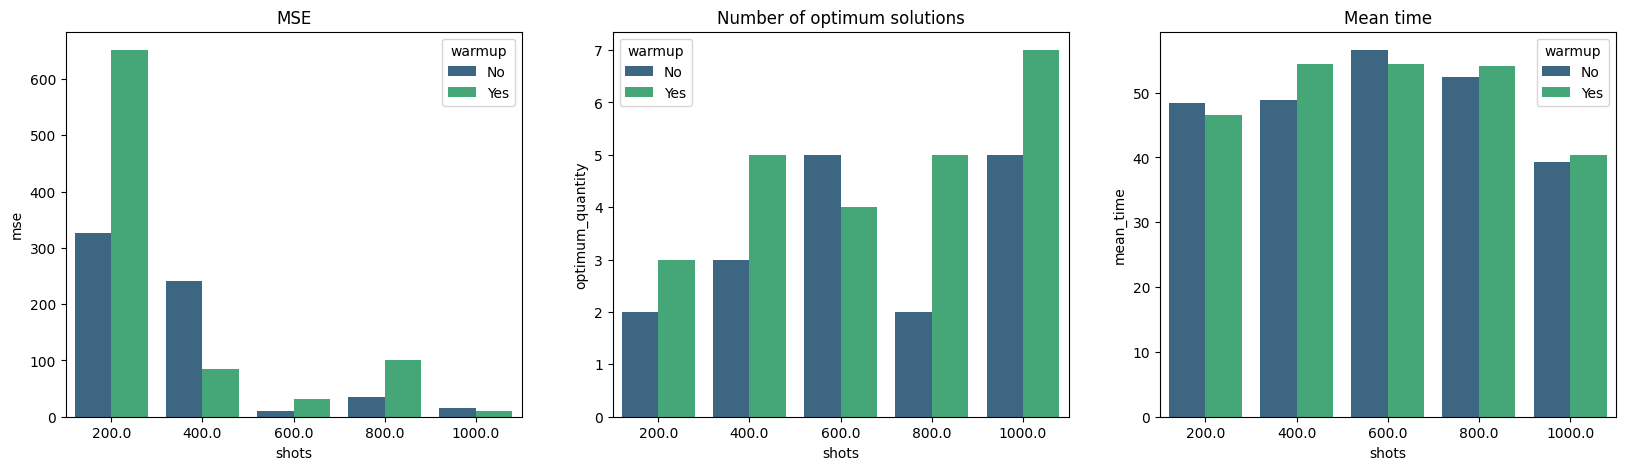

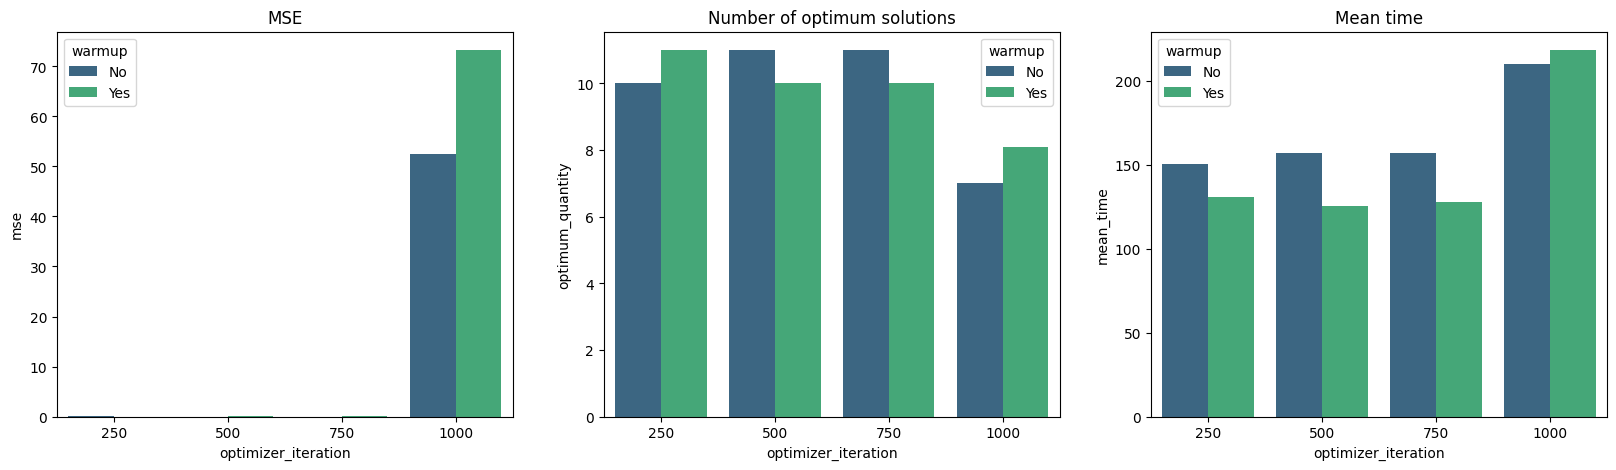

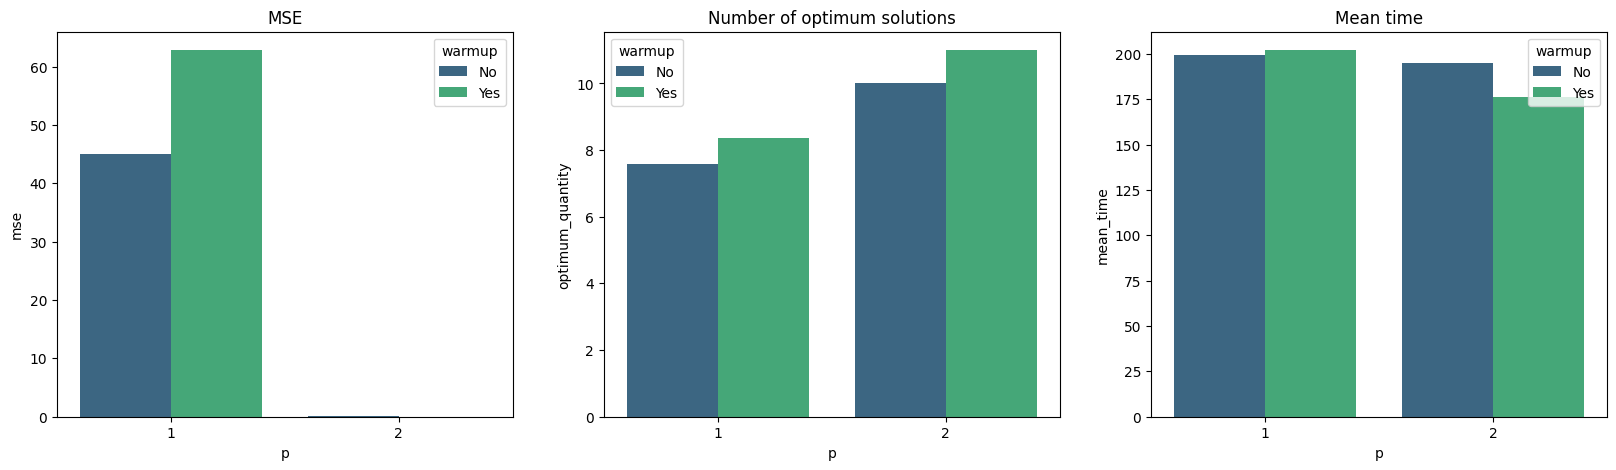

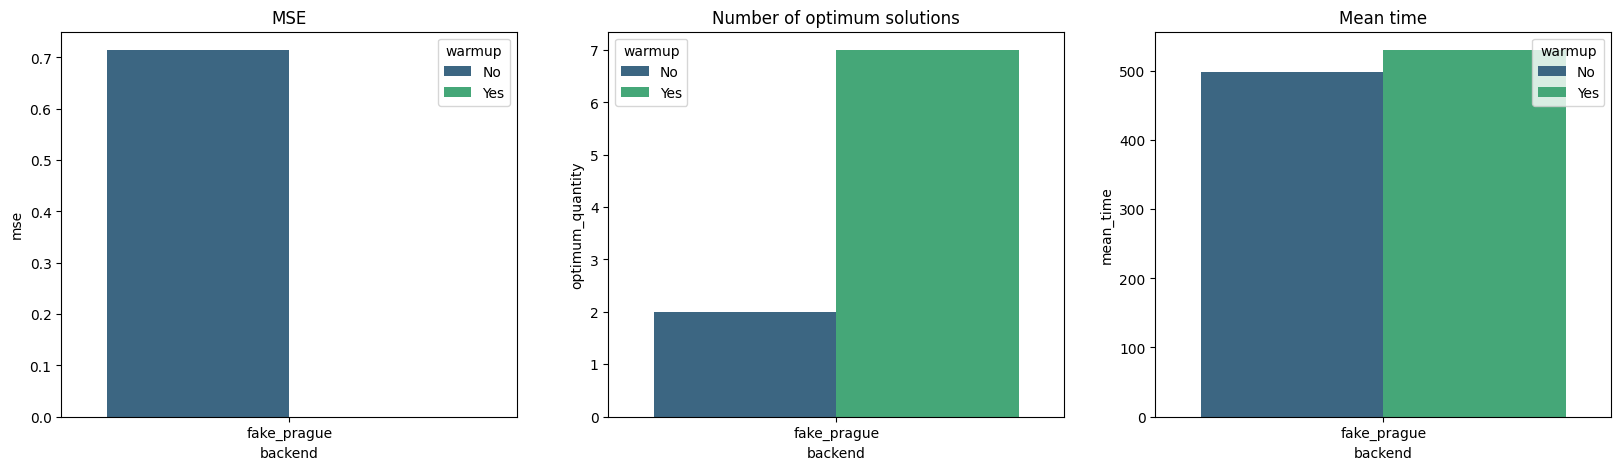

In [692]:
plot_results(pd.DataFrame(results))

### Result Analysis

This cell will provide some conclusions based on the metrics and plots displayed above. This is based on the instances we managed to run until the assignment's deadline, so not all examples are represented.

#### QAOA vs QAOA with warm start

As evident from the MSE and the count of achieved optimums, the solutions obtained by these two models exhibit remarkable similarity. There are only a few instances where one model outperforms the other, representing minor variations that could be deemed as edge cases. Notably, the warm start model consistently demonstrates better execution times. This outcome aligns with expectations, considering that the warm start model initializes with a classical result as the starting solution, positioning it closer to the optimum from the outset.

#### Optimisers

In terms of solution quality, Cobyla consistently outperforms, as evidenced by achieving a higher number of optimum solutions compared to the classical model. Cobyla also stands out as the model with the most efficient execution times, establishing itself as the optimal choice for this particular use case. The only aspect where it falls short in comparison to Nelder Mead is the Mean Squared Error (MSE), indicating that in instances where it doesn't attain the optimum, the model deviates significantly from the correct solution.

On the other hand, SPSA stand as the worst option, given by its high MSE and execution times.

#### Optimiser Iterations

With a few exceptions (edge cases), the solution quality of the models generally improves as the number of iterations used by the optimizers increases. However, this enhancement comes at the cost of increased execution times, highlighting a tradeoff between solution quality and computational efficiency.

#### P Value

Due to extensive execution times, we could only evaluate the P values of 1 and 2. Among these values, P=1 achieved more optimum solutions but also exhibited a higher MSE, indicating that its non-optimum solutions deviate significantly from the correct one. Opting for P=2 results in a substantial increase in execution times, introducing uncertainty regarding the best choice. The decision between P=1 and P=2 ultimately hinges on the specific use case and the goals of the algorithm's end users.

#### Number of Shots

The parameter that significantly impacted our experiment results was the number of shots. Merely specifying the number of shots in Qiskit's class, instead of relying on the default value, led to outcomes that were considerably distant from the optimum or even impossible. In our investigation, we believe we've identified the underlying reason for this behavior.

When the number of shots is left undefined in the sampler, Qiskit calculates the probabilities of the sampler and utilizes them as the result, as documented in the [Sampler's documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Sampler). If `shots` is defined, Qiskit then samples from multinomial distributions, introducing an associated error margin.

Understanding that specifying shots will consistently result in inferior outcomes compared to using probabilities, there remains the question of why the results deviate significantly from the optimum. In the abstract of [this article](https://arxiv.org/abs/2205.06845) (Anthony M. Polloreno, Graeme Smith, The QAOA with Few Measurements, 2023), it is recommended to use more than 1000 shots for approximately 10 qubits. In our scenario, with a maximum of 30 qubits, and the experiments using a maximum of 1000 shots, it becomes evident that the number of shots is insufficient.

Referencing a [Jupyter Notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/hybrid_quantum_algorithms/QAOA/QAOA_braket.ipynb) by Amazon Braket, for a small system with 10 qubits, optimal solutions can be found with an 80% success probability by taking at least ~1650 shots. However, for just 20 qubits, this number escalates to 1.7 × 10^6 with a naive approach. Even though Qiskit's implementation is a lot more sophisticated than the naive apprach, this likely elucidates why results with up to 1000 shots are not practical.

#### Noisy Simulator

Given the prolonged execution times, obtaining results from a noisy simulator was impractical, limited to only the smallest instances. In our experiments, we attempted to utilize the [FakePrague](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.FakePrague) provider, as it offers the closest number of qubits required (33 qubits, considering the maximum needed for the largest instance was 30).